In [1]:
import os
os.getcwd()


'C:\\Users\\saisr\\Desktop\\rtl_timing_ml'

In [2]:
print("Here:", os.listdir("."))
print("RTL folder:", os.listdir("rtl"))
print("Data folder:", os.listdir("data"))


Here: ['.ipynb_checkpoints', 'data', 'rtl', 'rtl_timing_pipeline.ipynb']
RTL folder: ['adder16.v', 'alu_simple.v', 'counter_modN.v', 'fsm_traffic.v', 'pipeline_datapath.v']
Data folder: ['timing_slack.csv']


In [3]:
!pip install pandas scikit-learn shap matplotlib

In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import shap


In [6]:
RTL_DIR = "rtl"

def extract_features_from_file(path):
    with open(path, "r") as f:
        text = f.read()

    # remove comments
    text = re.sub(r"//.*", "", text)
    text = re.sub(r"/\*.*?\*/", "", text, flags=re.S)

    lines = [ln for ln in text.splitlines() if ln.strip()]
    num_lines = len(lines)

    num_assign = len(re.findall(r"\bassign\b", text))
    num_always = len(re.findall(r"\balways\b", text))
    num_case   = len(re.findall(r"\bcase\b", text))
    num_if     = len(re.findall(r"\bif\s*\(", text))

    num_plus   = text.count("+")
    num_minus  = text.count("-")
    num_mult   = text.count("*")
    num_and    = text.count("&")
    num_or     = text.count("|")
    num_xor    = text.count("^")
    num_ternary = text.count("?")

    num_reg  = len(re.findall(r"\breg\b", text))
    num_wire = len(re.findall(r"\bwire\b", text))

    indent_levels = [len(ln) - len(ln.lstrip()) for ln in lines]
    approx_depth = max(indent_levels) if indent_levels else 0

    return {
        "num_lines": num_lines,
        "num_assign": num_assign,
        "num_always": num_always,
        "num_case": num_case,
        "num_if": num_if,
        "num_plus": num_plus,
        "num_minus": num_minus,
        "num_mult": num_mult,
        "num_and": num_and,
        "num_or": num_or,
        "num_xor": num_xor,
        "num_ternary": num_ternary,
        "num_reg": num_reg,
        "num_wire": num_wire,
        "approx_depth": approx_depth,
    }


In [7]:
rows = []

for fname in os.listdir(RTL_DIR):
    if not fname.endswith(".v"):
        continue
    path = os.path.join(RTL_DIR, fname)
    feats = extract_features_from_file(path)
    module_name = os.path.splitext(fname)[0]
    feats["module_name"] = module_name
    rows.append(feats)

features_df = pd.DataFrame(rows)
features_df = features_df[["module_name"] + [c for c in features_df.columns if c != "module_name"]]
features_df


,module_name,num_lines,num_assign,num_always,num_case,num_if,num_plus,num_minus,num_mult,num_and,num_or,num_xor,num_ternary,num_reg,num_wire,approx_depth
0,adder16,20,0,3,0,0,1,0,5,0,0,0,0,3,0,8
1,alu_simple,27,0,3,1,0,1,1,3,1,1,0,0,3,0,12
2,counter_modN,17,0,1,0,2,1,2,0,0,0,0,0,1,0,12
3,fsm_traffic,51,0,2,1,1,0,0,1,0,0,0,0,3,0,16
4,pipeline_datapath,28,1,3,0,3,2,0,2,1,0,1,0,1,0,12


In [8]:
slack_df = pd.read_csv("data/timing_slack.csv")
print("Timing slack CSV:")
display(slack_df)

dataset = pd.merge(features_df, slack_df, on="module_name")
print("\nMerged dataset (features + slack):")
display(dataset)


Timing slack CSV:


,module_name,slack_ns
0,adder16,7.551
1,alu_simple,6.570
2,counter_modN,8.305
3,fsm_traffic,8.784
4,pipeline_datapath,7.368



Merged dataset (features + slack):


,module_name,num_lines,num_assign,num_always,num_case,num_if,num_plus,num_minus,num_mult,num_and,num_or,num_xor,num_ternary,num_reg,num_wire,approx_depth,slack_ns
0,adder16,20,0,3,0,0,1,0,5,0,0,0,0,3,0,8,7.551
1,alu_simple,27,0,3,1,0,1,1,3,1,1,0,0,3,0,12,6.570
2,counter_modN,17,0,1,0,2,1,2,0,0,0,0,0,1,0,12,8.305
3,fsm_traffic,51,0,2,1,1,0,0,1,0,0,0,0,3,0,16,8.784
4,pipeline_datapath,28,1,3,0,3,2,0,2,1,0,1,0,1,0,12,7.368


In [9]:
X = dataset.drop(columns=["module_name", "slack_ns"])
y = dataset["slack_ns"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mpe = (np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-6)).mean() * 100
r2  = r2_score(y_test, y_pred)

print(f"MAE      = {mae:.3f} ns")
print(f"MPE      = {mpe:.2f} %")
print(f"R^2 score= {r2:.3f}")


MAE      = 1.152 ns
MPE      = 16.87 %
R^2 score= -8.104


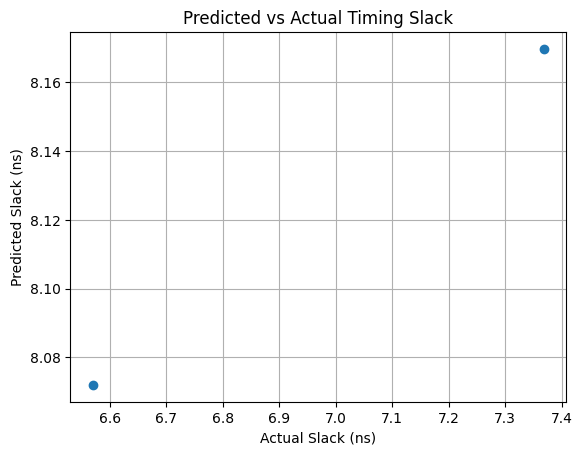

In [10]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Slack (ns)")
plt.ylabel("Predicted Slack (ns)")
plt.title("Predicted vs Actual Timing Slack")
plt.grid(True)
plt.savefig("data/pred_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()


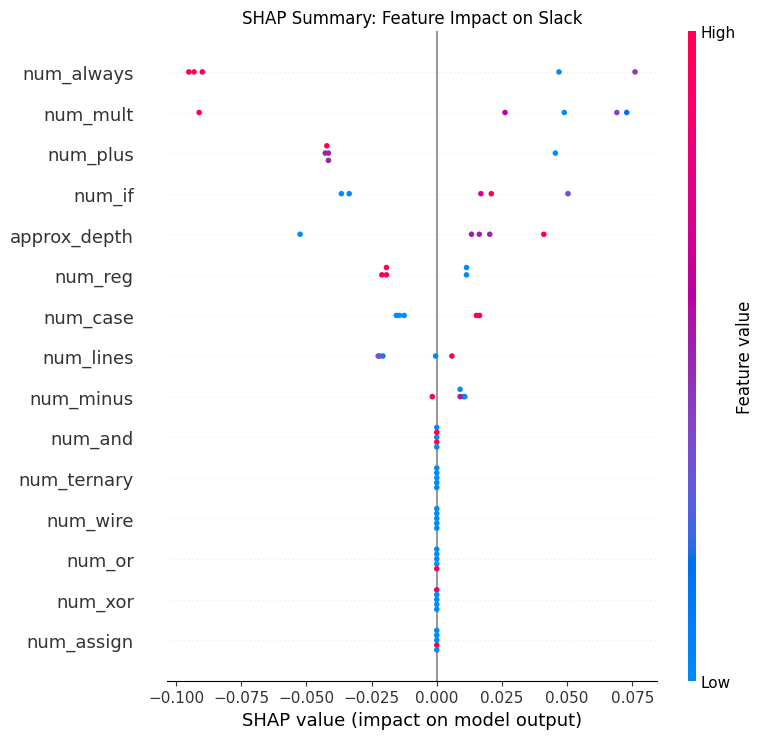

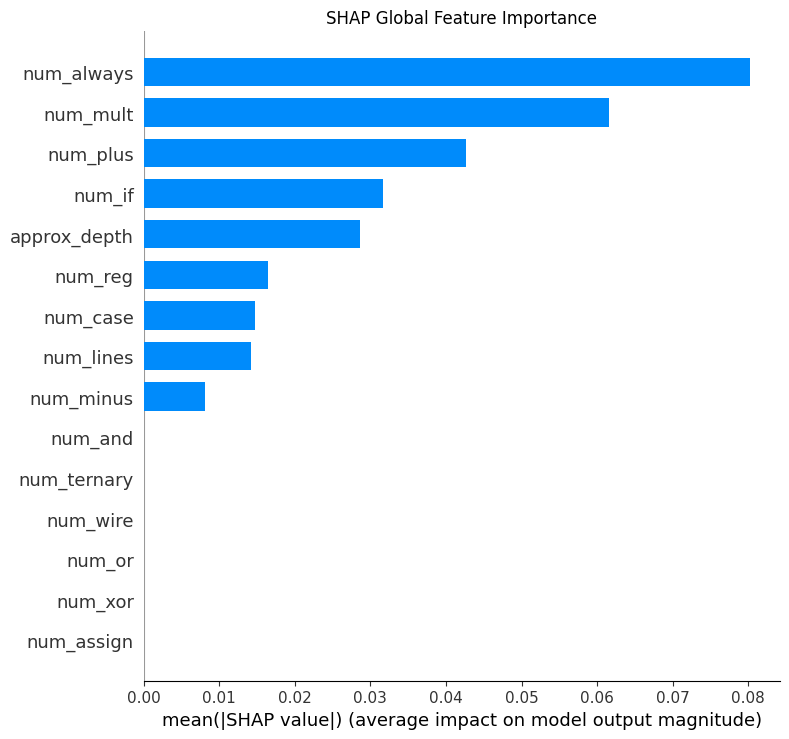

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Dot summary plot
shap.summary_plot(shap_values, X, show=False)
plt.title("SHAP Summary: Feature Impact on Slack")
plt.tight_layout()
plt.savefig("data/shap_summary.png", dpi=300)
plt.show()

# Bar-plot feature importance
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance")
plt.tight_layout()
plt.savefig("data/shap_bar.png", dpi=300)
plt.show()
